## Otimização de Estratégia de Manutenção com Simulação de Monte Carlo

**Objetivo:** Utilizar a Simulação de Monte Carlo para avaliar o custo total de diferentes políticas de manutenção ao longo de um período e determinar a estratégia mais econômica.

**Contexto:** A escolha de uma estratégia de manutenção (corretiva, preventiva, preditiva) tem um impacto financeiro direto na operação. Uma decisão errada pode levar a custos excessivos com reparos emergenciais, longos períodos de inatividade ou trocas prematuras de componentes. Como a falha de um equipamento é um evento **probabilístico**, não podemos usar cálculos simples para decidir.

**Por que Simulação de Monte Carlo?**
A Simulação de Monte Carlo nos permite modelar a incerteza do "tempo até a falha" de um componente. Ao simular milhares de cenários possíveis para a vida útil de um ativo sob diferentes regras de manutenção, podemos obter uma **distribuição estatística dos custos totais**. Isso nos permite comparar as estratégias não apenas pelo custo médio, mas também pelo **risco** (variabilidade dos custos).

**Estratégias a serem avaliadas:**
1.  **Corretiva (Run-to-Failure):** Reparar apenas após a falha.
2.  **Preventiva (Baseada no Tempo):** Intervir em intervalos fixos de tempo.
3.  **Preditiva (Baseada em Previsão):** Intervir com base em um alerta que antecede a falha.

### Configuração e Importação de Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Configurações de visualização
plt.rcParams['figure.figsize'] = (14, 7)

### Definição dos Parâmetros do Modelo

Nesta seção, definimos todas as premissas do nosso modelo: as características de falha do ativo e os custos associados a cada ação de manutenção.

In [2]:
# --- Parâmetros de Confiabilidade (Distribuição de Weibull) ---
# A Distribuição de Weibull é padrão para modelar tempo até a falha.
weibull_shape = 2.5  # Beta (β) > 1 indica falha por desgaste (envelhecimento)
weibull_scale = 3000  # Eta (η), vida característica em horas. A maioria das falhas ocorrerá em torno deste valor.

# --- Parâmetros de Custo ---
# Custos de Reparo
cost_corrective = 15000  # Custo de um reparo de emergência (alto)
cost_preventive = 4000  # Custo de uma substituição planejada (peças + mão de obra)
cost_predictive = 3500  # Custo de uma substituição just-in-time (menor que preventiva pois o planejamento é melhor)

# Custos de Inatividade (Downtime)
cost_downtime_per_hour = 500  # Custo da perda de produção por hora
downtime_corrective = 12  # Horas de inatividade para um reparo corretivo (longo)
downtime_preventive = 4  # Horas de inatividade para um reparo preventivo (curto)
downtime_predictive = 3  # Horas de inatividade para um reparo preditivo (mais curto)

# Custo de Monitoramento (apenas para Preditiva)
cost_monitoring_per_year = 2000

# --- Parâmetros da Estratégia Preventiva ---
preventive_interval_hours = 2000  # Fazer manutenção a cada 2000 horas

# --- Parâmetros da Estratégia Preditiva ---
predictive_warning_hours = (
    100  # Nosso sistema Preditivo nos dá um alerta 100 horas antes da falha
)

### Funções de Simulação de Monte Carlo

Vamos criar uma função para cada estratégia. Cada função irá simular a operação do ativo por um longo período, repetindo isso milhares de vezes para obter uma distribuição de custos.

In [3]:
def generate_ttf():
    """Gera um Tempo Até a Falha (Time to Failure) a partir da distribuição de Weibull."""
    return weibull_scale * np.random.weibull(weibull_shape)


def simulate_corrective(simulation_horizon_hours, n_simulations):
    """Simula a estratégia Corretiva (Run-to-Failure)."""
    total_costs = []
    cost_failure = cost_corrective + (downtime_corrective * cost_downtime_per_hour)

    for _ in range(n_simulations):
        current_time = 0
        sim_cost = 0
        while current_time < simulation_horizon_hours:
            ttf = generate_ttf()
            current_time += ttf
            if current_time < simulation_horizon_hours:
                sim_cost += cost_failure
        total_costs.append(sim_cost)
    return total_costs


def simulate_preventive(simulation_horizon_hours, n_simulations):
    """Simula a estratégia Preventiva (Baseada no Tempo)."""
    total_costs = []
    cost_failure = cost_corrective + (downtime_corrective * cost_downtime_per_hour)
    cost_pm = cost_preventive + (downtime_preventive * cost_downtime_per_hour)

    for _ in range(n_simulations):
        current_time = 0
        sim_cost = 0
        while current_time < simulation_horizon_hours:
            ttf = generate_ttf()
            if ttf < preventive_interval_hours:
                # Falhou antes da preventiva
                current_time += ttf
                if current_time < simulation_horizon_hours:
                    sim_cost += cost_failure
            else:
                # Intervenção preventiva bem-sucedida
                current_time += preventive_interval_hours
                if current_time < simulation_horizon_hours:
                    sim_cost += cost_pm
        total_costs.append(sim_cost)
    return total_costs


def simulate_predictive(simulation_horizon_hours, n_simulations):
    """Simula a estratégia Preditiva."""
    total_costs = []
    cost_pdm = cost_predictive + (downtime_predictive * cost_downtime_per_hour)
    # Custo de monitoramento é adicionado ao final
    monitoring_cost_total = (simulation_horizon_hours / 8760) * cost_monitoring_per_year

    for _ in range(n_simulations):
        current_time = 0
        sim_cost = 0
        while current_time < simulation_horizon_hours:
            ttf = generate_ttf()
            # A intervenção ocorre 'warning_hours' antes da falha
            intervention_time = ttf - predictive_warning_hours
            current_time += intervention_time
            if current_time < simulation_horizon_hours:
                sim_cost += cost_pdm
        total_costs.append(sim_cost + monitoring_cost_total)
    return total_costs

### Execução da Simulação

Vamos definir os parâmetros da simulação (quantas vezes repetir e por quanto tempo simular) e rodar as funções.

In [4]:
N_SIMULATIONS = 10000  # Número de "vidas" do ativo a simular
SIMULATION_HORIZON_YEARS = 5
SIMULATION_HORIZON_HOURS = SIMULATION_HORIZON_YEARS * 24 * 365

print(
    f"Iniciando simulações para um horizonte de {SIMULATION_HORIZON_YEARS} anos ({SIMULATION_HORIZON_HOURS} horas)..."
)

costs_corrective = simulate_corrective(SIMULATION_HORIZON_HOURS, N_SIMULATIONS)
costs_preventive = simulate_preventive(SIMULATION_HORIZON_HOURS, N_SIMULATIONS)
costs_predictive = simulate_predictive(SIMULATION_HORIZON_HOURS, N_SIMULATIONS)

print("Simulações concluídas!")

# Organizando os resultados em um DataFrame
results_df = pd.DataFrame(
    {
        "Corretiva": costs_corrective,
        "Preventiva": costs_preventive,
        "Preditiva": costs_predictive,
    }
)

Iniciando simulações para um horizonte de 5 anos (43800 horas)...
Simulações concluídas!


### Análise e Visualização dos Resultados

Esta é a parte mais importante. Vamos comparar as distribuições de custo para entender o desempenho e o risco de cada estratégia.

Text(0, 0.5, 'Custo Total (R$)')

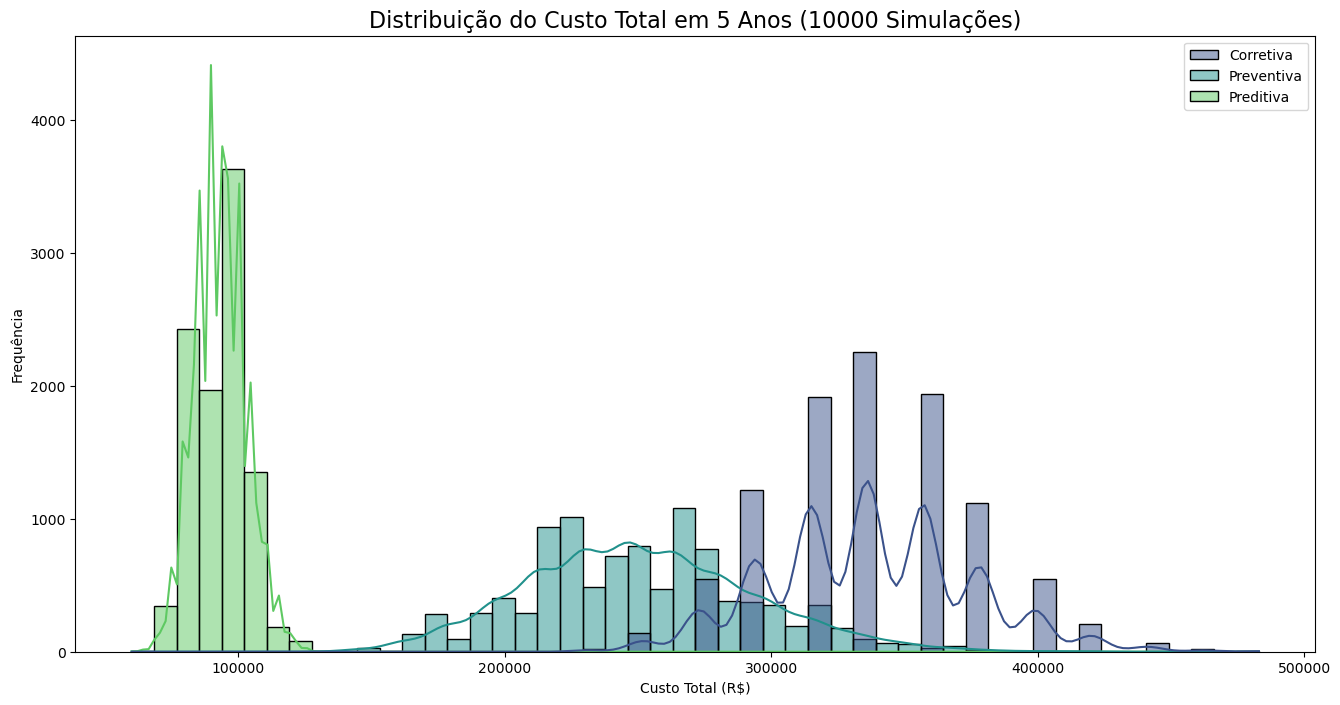

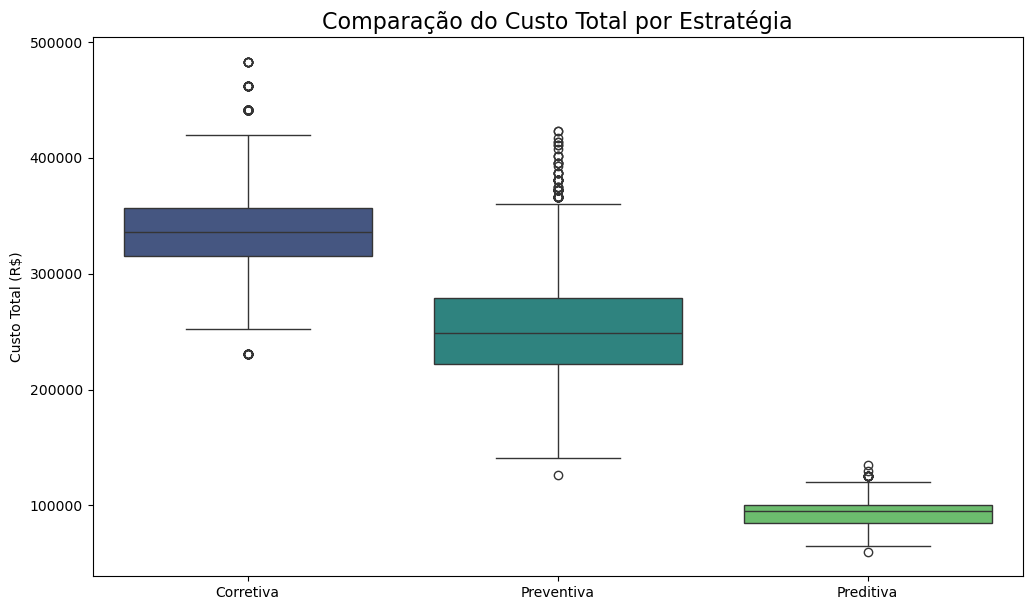

In [5]:
# Plotando histogramas das distribuições de custo
plt.figure(figsize=(16, 8))
sns.histplot(results_df, bins=50, kde=True, palette="viridis")
plt.title(
    f"Distribuição do Custo Total em {SIMULATION_HORIZON_YEARS} Anos ({N_SIMULATIONS} Simulações)",
    fontsize=16,
)
plt.xlabel("Custo Total (R$)")
plt.ylabel("Frequência")

# Plotando boxplots para comparar as estatísticas
plt.figure(figsize=(12, 7))
sns.boxplot(data=results_df, palette="viridis")
plt.title("Comparação do Custo Total por Estratégia", fontsize=16)
plt.ylabel("Custo Total (R$)")

#### Análise Estatística

In [6]:
summary = results_df.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.95]).transpose()
summary["Custo Médio"] = summary["mean"]
summary["Risco (Desv. Padrão)"] = summary["std"]
summary = summary[["Custo Médio", "Risco (Desv. Padrão)", "min", "50%", "max"]]
summary = summary.rename(columns={"50%": "Custo Mediano"})

print(f"Resumo Estatístico do Custo Total em {SIMULATION_HORIZON_YEARS} anos:")
summary.style.format("R$ {:,.2f}")

Resumo Estatístico do Custo Total em 5 anos:


,Custo Médio,Risco (Desv. Padrão),min,Custo Mediano,max
Corretiva,"R$ 337,031.10","R$ 37,409.52","R$ 231,000.00","R$ 336,000.00","R$ 483,000.00"
Preventiva,"R$ 250,754.70","R$ 42,267.99","R$ 126,000.00","R$ 249,000.00","R$ 423,000.00"
Preditiva,"R$ 93,390.00","R$ 9,435.93","R$ 60,000.00","R$ 95,000.00","R$ 135,000.00"


### Conclusão e Tomada de Decisão

**Análise dos Resultados:**

1.  **Estratégia Corretiva:** Apresenta o **maior custo médio** e, crucialmente, o **maior risco (desvio padrão)**. A cauda longa no histograma mostra que, embora às vezes possa ser barata (se o ativo tiver sorte e durar muito), ela também tem um potencial significativo para custos extremamente altos e imprevisíveis. É uma estratégia de alto risco.

2.  **Estratégia Preventiva:** Consegue **reduzir drasticamente o custo médio** em comparação com a corretiva. O risco também é muito menor, resultando em custos mais previsíveis. No entanto, ao intervir em um intervalo fixo (`2000h`), estamos potencialmente desperdiçando a vida útil restante do componente, já que a vida característica é de `3000h`.

3.  **Estratégia Preditiva:** Neste cenário, ela apresenta o **menor custo médio e mediano**. Mais importante ainda, ela tem o **menor risco (desvio padrão)**. A distribuição de custos é a mais estreita, o que significa que os custos anuais de manutenção para este ativo se tornam muito mais previsíveis e estáveis. O custo do monitoramento é mais do que compensado pela otimização do momento da intervenção.

**Decisão Estratégica:**

Com base nesta simulação, a **Estratégia Preditiva é a escolha ótima** para este ativo. Ela não apenas minimiza o custo total esperado ao longo de 5 anos, mas também oferece a maior previsibilidade financeira, permitindo um melhor planejamento orçamentário para a manutenção.